Abdullah Shakir

22I-1138

Messam Raza

22I-1194

Data Mining (CS-A)


# *Transformer-Based Anomaly Detection Framework*

## Overview
This notebook implements a state-of-the-art anomaly detection system for multivariate time series data using:

 1. **Transformer Autoencoder** - For temporal feature extraction and reconstruction
 2. **Contrastive Learning** - To distinguish normal vs. anomalous patterns
 3. **Generative Adversarial Network (GAN)** - To handle training data contamination
 4. **Geometric Masking** - Data augmentation for robustness

## Dataset
 **Credit Card Fraud Detection Dataset**
 - Source: Kaggle/ULB Machine Learning Group
 - Features: 28 PCA-transformed features + Time + Amount
 - Task: Detect fraudulent transactions (highly imbalanced)

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




 ## 📚 Section 1: Imports and Configuration



In [36]:
# Core libraries
import os
import math
import random
import warnings
warnings.filterwarnings("ignore")

# Set CUDA debugging (helps identify errors)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Data processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    roc_curve,
    classification_report,
    confusion_matrix,
    f1_score
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from collections import Counter

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

✓ All libraries imported successfully



## ⚙️ Section 2: Hyperparameters and Configuration



In [3]:
# ============================================================================
# CUDA SETUP (WITH ERROR HANDLING)
# ============================================================================

def setup_device():
    """Setup compute device with proper error handling."""
    if torch.cuda.is_available():
        try:
            # Test CUDA availability
            torch.cuda.empty_cache()
            test_tensor = torch.zeros(1).cuda()
            del test_tensor
            torch.cuda.empty_cache()
            device = torch.device("cuda")
            print(f"✓ CUDA is available: {torch.cuda.get_device_name(0)}")
            print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        except Exception as e:
            print(f"⚠️ CUDA error: {e}")
            print("  Falling back to CPU")
            device = torch.device("cpu")
    else:
        device = torch.device("cpu")
        print("✓ Using CPU (CUDA not available)")
    return device

DEVICE = setup_device()

# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

# Data paths
DATA_PATH = "/content/drive/MyDrive/Credit-Card-Fraud-Anomaly-Detection/data/creditcard.csv"

# Sequence generation
WINDOW_SIZE = 10          # Sliding window size for time series
STEP = 1                  # Step size for sliding window

# Model architecture
D_MODEL = 64              # Transformer embedding dimension
NHEAD = 4                 # Number of attention heads
NUM_ENCODER_LAYERS = 2    # Number of transformer encoder layers
LATENT_DIM = 64           # Latent space dimensionality

# Training hyperparameters
BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 5e-4      # Initial learning rate

# Loss weights
W_RECON = 0.3             # Reconstruction loss weight
W_CONTRAST = 0.2          # Contrastive loss weight
W_CLASS = 1.0             # Classification loss weight (NEW for supervised)
W_ADV = 0.01              # Adversarial loss weight

# GAN training stability
N_CRITIC = 5              # Update discriminator every N batches
CLIP_VALUE = 0.01         # Weight clipping for WGAN

# Data augmentation
TIME_MASK_PROB = 0.1      # Probability of masking time steps
FEATURE_MASK_PROB = 0.1   # Probability of masking features
NOISE_STD = 0.01          # Gaussian noise standard deviation

# Random seed
SEED = 42

# ============================================================================
# SET RANDOM SEEDS (WITH ERROR HANDLING)
# ============================================================================

def set_seeds(seed):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        try:
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        except Exception as e:
            print(f"⚠️ CUDA seed warning: {e}")

    print(f"✓ Random seeds set to {seed}")

set_seeds(SEED)

print(f"\n✓ Configuration loaded")
print(f"✓ Device: {DEVICE}")

✓ All libraries imported successfully
✓ CUDA is available: Tesla T4
  Memory: 15.8 GB
✓ Random seeds set to 42

✓ Configuration loaded
✓ Device: cuda



 ## 📊 Section 3: Data Loading and Preprocessing



In [4]:

# ============================================================================
# DATA LOADING
# ============================================================================

assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH}"

print("Loading dataset...")
df = pd.read_csv(DATA_PATH)

print(f"✓ Dataset loaded: {df.shape[0]} transactions")
print(f"✓ Columns: {list(df.columns)}")
print(f"\nClass distribution:")
print(df['Class'].value_counts())
print(f"\nFraud ratio: {df['Class'].mean():.4%}")

# %%
# ============================================================================
# DATA PREPROCESSING
# ============================================================================

# Select features (exclude Time and Class)
features = [c for c in df.columns if c not in ['Class', 'Time']]
print(f"\n✓ Selected {len(features)} features for modeling")

# Standardize features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])
print("✓ Features standardized (mean=0, std=1)")

# Sort by time to preserve temporal ordering
data = df.sort_values('Time').reset_index(drop=True)
print("✓ Data sorted by time")


Loading dataset...
✓ Dataset loaded: 284807 transactions
✓ Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Fraud ratio: 0.1727%

✓ Selected 29 features for modeling
✓ Features standardized (mean=0, std=1)
✓ Data sorted by time


 ## 🔄 Section 4: Sliding Window Sequence Generation



In [5]:

# ============================================================================
# SLIDING WINDOW SEQUENCE GENERATION
# ============================================================================

print(f"Generating sliding window sequences...")
print(f"  Window size: {WINDOW_SIZE}")
print(f"  Step size: {STEP}")

X = data[features].values
y = data['Class'].values

sequences = []
labels = []

for i in range(0, len(X) - WINDOW_SIZE + 1, STEP):
    seq = X[i:i+WINDOW_SIZE]
    # Label window as anomalous if ANY transaction in window is fraud
    label = 1 if y[i:i+WINDOW_SIZE].sum() > 0 else 0
    sequences.append(seq)
    labels.append(label)

sequences = np.stack(sequences)
labels = np.array(labels)

print(f"\n✓ Generated {len(sequences)} sequences")
print(f"  Shape: {sequences.shape}")
print(f"  Anomaly ratio: {labels.mean():.4%}")



Generating sliding window sequences...
  Window size: 10
  Step size: 1

✓ Generated 284798 sequences
  Shape: (284798, 10, 29)
  Anomaly ratio: 1.5572%


In [6]:
# ============================================================================
# TRAIN-TEST SPLIT
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    sequences,
    labels,
    test_size=0.2,
    random_state=SEED,
    stratify=labels
)

# For unsupervised training, use only normal windows
train_normal = X_train[y_train == 0]

print(f"\n✓ Train-test split completed:")
print(f"  Total train: {len(X_train)} ({len(X_train)/len(sequences):.1%})")
print(f"  Total test: {len(X_test)} ({len(X_test)/len(sequences):.1%})")
print(f"  Normal train windows: {len(train_normal)}")
print(f"  Test anomaly ratio: {y_test.mean():.4%}")



✓ Train-test split completed:
  Total train: 227838 (80.0%)
  Total test: 56960 (20.0%)
  Normal train windows: 224290
  Test anomaly ratio: 1.5572%


In [7]:

# ============================================================================
# TIME-SERIES SMOTE
# ============================================================================

from collections import Counter
from sklearn.neighbors import NearestNeighbors

class TimeSeriesSMOTE:
    """
    SMOTE adapted for multivariate time series sequences.
    Generates synthetic anomalies by interpolating in feature space
    while preserving temporal structure.
    """

    def __init__(self, k_neighbors=5, random_state=42):
        self.k_neighbors = k_neighbors
        self.random_state = random_state
        np.random.seed(random_state)

    def fit_resample(self, X, y):
        """
        Oversample minority class (anomalies).

        Args:
            X: numpy array of shape (N, T, F)
            y: numpy array of shape (N,)

        Returns:
            X_resampled, y_resampled
        """
        # Separate classes
        X_majority = X[y == 0]
        X_minority = X[y == 1]

        n_majority = len(X_majority)
        n_minority = len(X_minority)
        n_synthetic = n_majority - n_minority

        print(f"Generating {n_synthetic} synthetic anomaly samples...")

        if n_minority < self.k_neighbors:
            print(f"Warning: k_neighbors ({self.k_neighbors}) > minority samples ({n_minority})")
            self.k_neighbors = max(1, n_minority - 1)

        # Flatten for distance computation
        X_minority_flat = X_minority.reshape(n_minority, -1)

        # Find k nearest neighbors for each minority sample
        nn = NearestNeighbors(n_neighbors=self.k_neighbors + 1)
        nn.fit(X_minority_flat)

        synthetic_samples = []

        for i in range(n_synthetic):
            # Randomly select a minority sample
            idx = np.random.randint(0, n_minority)
            sample = X_minority[idx]

            # Find its neighbors
            distances, indices = nn.kneighbors([X_minority_flat[idx]])
            neighbor_idx = indices[0, np.random.randint(1, len(indices[0]))]
            neighbor = X_minority[neighbor_idx]

            # Interpolate (preserving temporal structure)
            alpha = np.random.uniform(0, 1)
            synthetic = sample + alpha * (neighbor - sample)

            # Add small noise to each timestep independently
            noise = np.random.normal(0, 0.01, synthetic.shape)
            synthetic = synthetic + noise

            synthetic_samples.append(synthetic)

        synthetic_samples = np.array(synthetic_samples)

        # Combine all samples
        X_resampled = np.concatenate([X, synthetic_samples], axis=0)
        y_resampled = np.concatenate([y, np.ones(n_synthetic)], axis=0)

        # Shuffle
        shuffle_idx = np.random.permutation(len(X_resampled))
        X_resampled = X_resampled[shuffle_idx]
        y_resampled = y_resampled[shuffle_idx]

        return X_resampled, y_resampled

# Apply Time Series SMOTE
print("\n" + "="*70)
print("APPLYING TIME-SERIES SMOTE")
print("="*70)

print(f"\nClass distribution BEFORE SMOTE:")
print(f"  Normal (0): {(y_train == 0).sum()}")
print(f"  Anomaly (1): {(y_train == 1).sum()}")

ts_smote = TimeSeriesSMOTE(k_neighbors=5, random_state=SEED)
X_train_resampled, y_train_resampled = ts_smote.fit_resample(X_train, y_train)

print(f"\nClass distribution AFTER SMOTE:")
print(f"  Normal (0): {int((y_train_resampled == 0).sum())}")
print(f"  Anomaly (1): {int((y_train_resampled == 1).sum())}")
print(f"  Total samples: {len(X_train_resampled)}")

# Update train_normal to use resampled data for normal samples
train_normal = X_train_resampled[y_train_resampled == 0]

print(f"\n✓ SMOTE applied successfully!")


APPLYING TIME-SERIES SMOTE

Class distribution BEFORE SMOTE:
  Normal (0): 224290
  Anomaly (1): 3548
Generating 220742 synthetic anomaly samples...

Class distribution AFTER SMOTE:
  Normal (0): 224290
  Anomaly (1): 224290
  Total samples: 448580

✓ SMOTE applied successfully!


 ## 🎲 Section 5: Dataset Class and Data Augmentation



In [8]:
# ============================================================================
# PYTORCH DATASET
# ============================================================================

class SequenceDataset(Dataset):
    """PyTorch Dataset for multivariate time series sequences."""

    def __init__(self, sequences, labels=None):
        """
        Args:
            sequences: numpy array of shape (N, T, F)
            labels: optional numpy array of shape (N,)
        """
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = None if labels is None else torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if self.labels is None:
            return self.sequences[idx]
        return self.sequences[idx], self.labels[idx]

print("✓ Dataset class defined")

✓ Dataset class defined


In [9]:

# ============================================================================
# DATA AUGMENTATION: GEOMETRIC MASKING
# ============================================================================

def geometric_masking(batch, time_mask_prob=0.1, feature_mask_prob=0.1, noise_std=0.01):
    """
    Apply geometric masking augmentation to time series batch.

    Techniques:
    1. Time masking: Randomly mask entire time steps
    2. Feature masking: Randomly mask entire features
    3. Gaussian noise: Add small random noise

    Args:
        batch: Tensor of shape (B, T, F)
        time_mask_prob: Probability of masking a time step
        feature_mask_prob: Probability of masking a feature
        noise_std: Standard deviation of Gaussian noise

    Returns:
        Augmented batch of same shape
    """
    augmented = batch.clone()
    B, T, F = augmented.shape

    # Time masking: mask random time steps
    time_mask = (torch.rand(B, T, device=batch.device) < time_mask_prob).unsqueeze(-1)
    augmented = augmented.masked_fill(time_mask, 0.0)

    # Feature masking: mask random features
    feat_mask = (torch.rand(B, 1, F, device=batch.device) < feature_mask_prob)
    augmented = augmented.masked_fill(feat_mask, 0.0)

    # Add Gaussian noise
    augmented = augmented + torch.randn_like(augmented) * noise_std

    return augmented

print("✓ Data augmentation function defined")


✓ Data augmentation function defined


 ## 🏗️ Section 6: Model Architecture

 ### 6.1 Positional Encoding

In [10]:

# ============================================================================
# POSITIONAL ENCODING
# ============================================================================

class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding for Transformer."""

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        """Add positional encoding to input."""
        return x + self.pe[:, :x.size(1)]

print("✓ Positional encoding defined")


✓ Positional encoding defined


 ### 6.2 Transformer Autoencoder


In [11]:
# ============================================================================
# TRANSFORMER AUTOENCODER WITH CLASSIFICATION HEAD (FIXED)
# ============================================================================

class TransformerAutoencoder(nn.Module):
    """
    Transformer-based autoencoder with classification head for supervised anomaly detection.
    """

    def __init__(self, feat_dim, d_model=64, nhead=4, num_layers=2, latent_dim=64):
        super().__init__()

        # ===== ENCODER =====
        self.input_fc = nn.Linear(feat_dim, d_model)
        self.pos = PositionalEncoding(d_model, max_len=200)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=128,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.latent = nn.Linear(d_model, latent_dim)

        # ===== DECODER =====
        self.decoder_fc = nn.Linear(latent_dim, d_model)

        decoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=128,
            batch_first=True
        )
        self.decoder_transformer = nn.TransformerEncoder(decoder_layer, num_layers=1)

        self.output_fc = nn.Linear(d_model, feat_dim)

        # ===== CLASSIFICATION HEAD (WITHOUT SIGMOID - will use BCEWithLogitsLoss) =====
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
            # NO Sigmoid here - we'll use BCEWithLogitsLoss which is more stable
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Xavier uniform initialization for all parameters."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def encode(self, x):
        h = self.input_fc(x)
        h = self.pos(h)
        h = self.transformer(h)
        pooled = self.pool(h.transpose(1, 2)).squeeze(-1)
        z = self.latent(pooled)
        return z

    def decode(self, z, seq_len):
        h = self.decoder_fc(z).unsqueeze(1).repeat(1, seq_len, 1)
        h = self.decoder_transformer(h)
        out = self.output_fc(h)
        return out

    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z, x.size(1))
        logits = self.classifier(z)  # Raw logits (no sigmoid)
        return z, recon, logits

print("✓ Transformer Autoencoder with Classification Head defined")

✓ Transformer Autoencoder with Classification Head defined


 ### 6.3 GAN Components (Generator & Discriminator)


In [12]:

# ============================================================================
# GENERATOR (LATENT SPACE)
# ============================================================================

def build_generator(latent_dim):
    """
    Build generator network for GAN in latent space.
    Maps random noise to latent representations.
    """
    gen = nn.Sequential(
        nn.Linear(16, latent_dim),
        nn.LayerNorm(latent_dim),
        nn.ReLU(),
        nn.Linear(latent_dim, latent_dim)
    )

    # Xavier initialization
    for p in gen.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return gen

print("✓ Generator defined")



✓ Generator defined


In [13]:

# ============================================================================
# DISCRIMINATOR (LATENT SPACE)
# ============================================================================

def build_discriminator(latent_dim):
    """
    Build discriminator network for GAN in latent space.
    Distinguishes real latent vectors from generated ones.
    """
    disc = nn.Sequential(
        nn.Linear(latent_dim, 64),
        nn.LayerNorm(64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.LayerNorm(32),
        nn.ReLU(),
        nn.Linear(32, 1)
    )

    # Xavier initialization
    for p in disc.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

    return disc

print("✓ Discriminator defined")


✓ Discriminator defined


 ### 6.4 Contrastive Loss Function


In [14]:

# ============================================================================
# NT-XENT CONTRASTIVE LOSS
# ============================================================================

def nt_xent_loss(z1, z2, temperature=0.5):
    """
    Normalized Temperature-scaled Cross Entropy Loss (NT-Xent).

    Used in contrastive learning to bring similar samples together
    and push dissimilar samples apart in latent space.

    Args:
        z1, z2: Two augmented views of same samples (B, D)
        temperature: Temperature parameter for scaling

    Returns:
        loss: Scalar contrastive loss
    """
    # Normalize embeddings
    z1 = F.normalize(z1, dim=1, eps=1e-8)
    z2 = F.normalize(z2, dim=1, eps=1e-8)
    B = z1.size(0)

    # Concatenate both views
    z = torch.cat([z1, z2], dim=0)  # (2B, D)

    # Compute similarity matrix
    sim = torch.matmul(z, z.T) / temperature  # (2B, 2B)

    # Mask out self-similarities
    mask = torch.eye(2*B, dtype=torch.bool, device=z.device)
    sim = sim.masked_fill(mask, -1e9)

    # Labels: positive pairs are (z1[i], z2[i])
    labels = torch.cat([
        torch.arange(B, 2*B),
        torch.arange(0, B)
    ], dim=0).to(z.device)

    # Compute cross-entropy loss (numerically stable)
    loss = F.cross_entropy(sim, labels)

    return loss

print("✓ Contrastive loss function defined")


✓ Contrastive loss function defined


 ## 🔧 Section 7: Model Initialization


In [15]:

# ============================================================================
# INSTANTIATE MODELS
# ============================================================================

feat_dim = len(features)

print("Initializing models...")
print(f"  Feature dimension: {feat_dim}")
print(f"  Latent dimension: {LATENT_DIM}")

# Main autoencoder
model = TransformerAutoencoder(
    feat_dim=feat_dim,
    d_model=D_MODEL,
    nhead=NHEAD,
    num_layers=NUM_ENCODER_LAYERS,
    latent_dim=LATENT_DIM
).to(DEVICE)

# GAN components
generator = build_generator(latent_dim=LATENT_DIM).to(DEVICE)
discriminator = build_discriminator(latent_dim=LATENT_DIM).to(DEVICE)

print(f"✓ Models initialized and moved to {DEVICE}")

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel sizes:")
print(f"  Autoencoder: {count_parameters(model):,} parameters")
print(f"  Generator: {count_parameters(generator):,} parameters")
print(f"  Discriminator: {count_parameters(discriminator):,} parameters")
print(f"  Total: {count_parameters(model) + count_parameters(generator) + count_parameters(discriminator):,} parameters")



Initializing models...
  Feature dimension: 29
  Latent dimension: 64
✓ Models initialized and moved to cuda

Model sizes:
  Autoencoder: 114,654 parameters
  Generator: 5,376 parameters
  Discriminator: 6,465 parameters
  Total: 126,495 parameters


In [16]:

# ============================================================================
# OPTIMIZERS
# ============================================================================

optimizer_ae = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)

print("✓ Optimizers initialized")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Optimizer: Adam")



✓ Optimizers initialized
  Learning rate: 0.0005
  Optimizer: Adam


In [17]:
# ============================================================================
# DATA LOADER (USE RESAMPLED DATA)
# ============================================================================

# Use SMOTE-balanced data for training
train_dataset = SequenceDataset(X_train_resampled, y_train_resampled)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

print(f"✓ DataLoader created with SMOTE-balanced data")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Number of batches: {len(train_loader)}")
print(f"  Total training samples: {len(train_dataset)}")

✓ DataLoader created with SMOTE-balanced data
  Batch size: 256
  Number of batches: 1752
  Total training samples: 448580


 ## 🚀 Section 8: Training Loop

In [19]:
import torch.distributed as dist
# ============================================================================
# SUPERVISED TRAINING LOOP
# ============================================================================

print("="*70)
print("STARTING SUPERVISED TRAINING WITH SMOTE DATA")
print("="*70)

# Loss weights
W_RECON = 0.3          # Reconstruction loss weight
W_CONTRAST = 0.2       # Contrastive loss weight
W_CLASS = 1.0          # Classification loss weight (NEW)
W_ADV = 0.01           # Adversarial loss weight

# Classification loss
class_criterion = nn.BCELoss()

# Training history
history = {
    'epoch': [],
    'recon_loss': [],
    'contrast_loss': [],
    'class_loss': [],      # NEW
    'enc_adv_loss': [],
    'disc_loss': [],
    'gen_loss': []
}

for epoch in range(EPOCHS):
    model.train()
    generator.train()
    discriminator.train()

    # Accumulators
    epoch_recon = 0.0
    epoch_contrast = 0.0
    epoch_class = 0.0      # NEW
    epoch_encadv = 0.0
    epoch_disc = 0.0
    epoch_gen = 0.0

    for batch_idx, (batch, batch_labels) in enumerate(train_loader):
        batch = batch.to(DEVICE)
        batch_labels = batch_labels.to(DEVICE).unsqueeze(1)  # Shape: (B, 1)

        # ===== CREATE AUGMENTED VIEWS =====
        view1 = geometric_masking(batch, TIME_MASK_PROB, FEATURE_MASK_PROB, NOISE_STD)
        view2 = geometric_masking(batch, TIME_MASK_PROB, FEATURE_MASK_PROB, NOISE_STD)

        # ===== FORWARD PASS =====
        z1, recon1, pred1 = model(view1)
        z2, recon2, pred2 = model(view2)
        z_orig, recon_orig, pred_orig = model(batch)

        # Add checks for NaNs or Infs in z_orig
        if torch.isnan(z_orig).any() or torch.isinf(z_orig).any():
            print(f"Warning: NaN or Inf detected in z_orig at epoch {epoch+1}, batch {batch_idx}")
            # You might want to break, or handle this more gracefully, e.g., by skipping the batch
            continue

        # ===== 1. UPDATE AUTOENCODER =====
        optimizer_ae.zero_grad()

        # Reconstruction loss
        recon_loss = F.mse_loss(recon_orig, batch)

        # Contrastive loss
        contrast_loss = nt_xent_loss(z1, z2, temperature=0.5)

        # Classification loss (NEW)
        # Ensure pred_orig is between 0 and 1 for BCELoss (if it's logits, use BCEWithLogitsLoss)
        # Given BCEWithLogitsLoss is usually used with raw logits, let's assume pred_orig are logits.
        # If pred_orig is already a probability, then sigmoid is not needed.
        # Since the classifier does NOT have sigmoid, it's logits. BCEWithLogitsLoss is appropriate.
        class_loss = F.binary_cross_entropy_with_logits(pred_orig, batch_labels)

        # Adversarial loss
        enc_adv = -torch.mean(discriminator(z_orig))

        # Combined loss
        ae_loss = (W_RECON * recon_loss +
                   W_CONTRAST * contrast_loss +
                   W_CLASS * class_loss +           # NEW
                   W_ADV * enc_adv)

        ae_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer_ae.step()

        # ===== 2. UPDATE DISCRIMINATOR =====
        if batch_idx % N_CRITIC == 0:
            for _ in range(N_CRITIC):
                optimizer_disc.zero_grad()

                noise = torch.randn(batch.size(0), 16, device=DEVICE)
                fake = generator(noise)

                with torch.no_grad():
                    z_real = model.encode(batch)

                # Add checks for NaNs or Infs in z_real
                if torch.isnan(z_real).any() or torch.isinf(z_real).any():
                    print(f"Warning: NaN or Inf detected in z_real (for disc) at epoch {epoch+1}, batch {batch_idx}")
                    # Decide how to handle this, e.g., skip discriminator update or entire batch
                    continue # Skip current discriminator update step

                real_scores = discriminator(z_real)
                fake_scores = discriminator(fake.detach())

                disc_loss = -torch.mean(real_scores) + torch.mean(fake_scores)

                disc_loss.backward()
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
                optimizer_disc.step()

                for p in discriminator.parameters():
                    p.data.clamp_(-CLIP_VALUE, CLIP_VALUE)

        # ===== 3. UPDATE GENERATOR =====
        if batch_idx % N_CRITIC == 0:
            optimizer_gen.zero_grad()

            noise = torch.randn(batch.size(0), 16, device=DEVICE)
            fake = generator(noise)
            gen_loss = -torch.mean(discriminator(fake))

            gen_loss.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
            optimizer_gen.step()

            epoch_gen += gen_loss.item()

        # Accumulate losses
        epoch_recon += recon_loss.item()
        epoch_contrast += contrast_loss.item()
        epoch_class += class_loss.item()      # NEW
        epoch_encadv += enc_adv.item()
        if batch_idx % N_CRITIC == 0:
            epoch_disc += disc_loss.item()

    # Calculate averages
    n_batches = len(train_loader)
    n_disc_updates = max(n_batches // N_CRITIC, 1)

    avg_recon = epoch_recon / n_batches
    avg_contrast = epoch_contrast / n_batches
    avg_class = epoch_class / n_batches        # NEW
    avg_encadv = epoch_encadv / n_batches
    avg_disc = epoch_disc / n_disc_updates
    avg_gen = epoch_gen / n_disc_updates

    # Store history
    history['epoch'].append(epoch + 1)
    history['recon_loss'].append(avg_recon)
    history['contrast_loss'].append(avg_contrast)
    history['class_loss'].append(avg_class)    # NEW
    history['enc_adv_loss'].append(avg_encadv)
    history['disc_loss'].append(avg_disc)
    history['gen_loss'].append(avg_gen)

    # Print progress
    print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
          f"Recon: {avg_recon:.6f} | "
          f"Class: {avg_class:.6f} | "          # NEW
          f"Contrast: {avg_contrast:.6f} | "
          f"Disc: {avg_disc:.6f} |"
          f"EncAdv: {avg_encadv:.6f} |"
          f"Gen: {avg_gen:.6f} ")

print("\n" + "="*70)
print("TRAINING COMPLETED")
print("="*70)


STARTING SUPERVISED TRAINING WITH SMOTE DATA
Epoch   1/20 | Recon: 1.549927 | Class: 0.007882 | Contrast: 4.698626 | Disc: -0.005108 |Gen: 0.012572 
Epoch   2/20 | Recon: 1.546093 | Class: 0.005961 | Contrast: 4.682090 | Disc: -0.005136 |Gen: 0.012598 
Epoch   3/20 | Recon: 1.544039 | Class: 0.004830 | Contrast: 4.668225 | Disc: -0.005059 |Gen: 0.012530 
Epoch   4/20 | Recon: 1.542774 | Class: 0.004140 | Contrast: 4.656289 | Disc: -0.005228 |Gen: 0.012644 
Epoch   5/20 | Recon: 1.541721 | Class: 0.003599 | Contrast: 4.646769 | Disc: -0.005212 |Gen: 0.012640 
Epoch   6/20 | Recon: 1.541098 | Class: 0.003532 | Contrast: 4.638010 | Disc: -0.005132 |Gen: 0.012586 
Epoch   7/20 | Recon: 1.540393 | Class: 0.002663 | Contrast: 4.628504 | Disc: -0.005053 |Gen: 0.012533 
Epoch   8/20 | Recon: 1.540347 | Class: 0.003040 | Contrast: 4.624740 | Disc: -0.005229 |Gen: 0.012644 
Epoch   9/20 | Recon: 1.539689 | Class: 0.002460 | Contrast: 4.617371 | Disc: -0.005225 |Gen: 0.012643 
Epoch  10/20 | Reco

 ## 📈 Section 9: Training Visualization

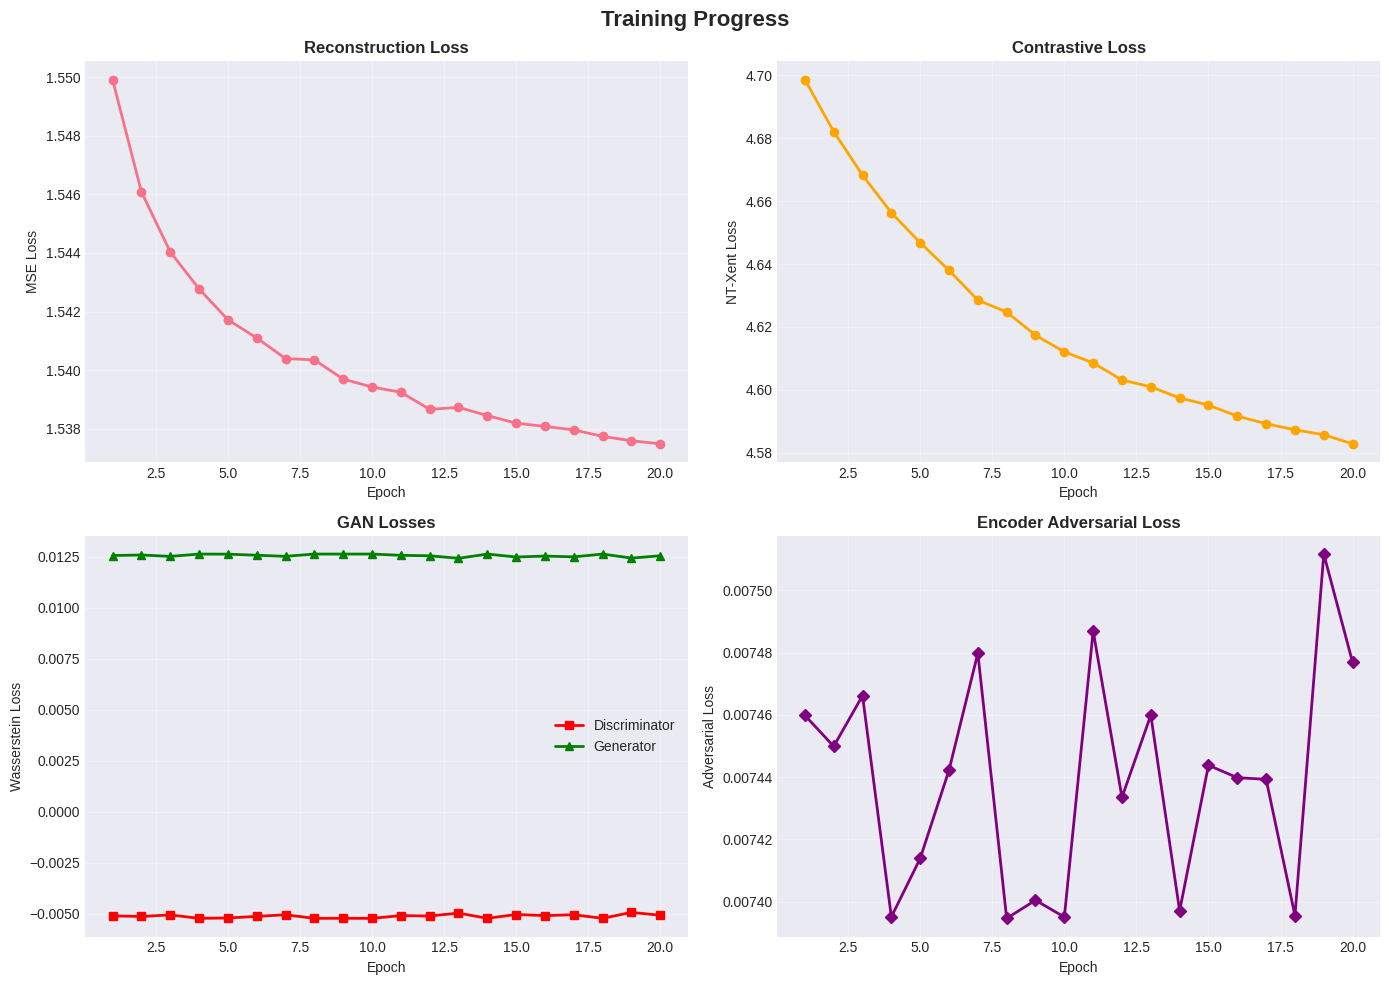

✓ Training curves plotted


In [20]:


# ============================================================================
# PLOT TRAINING CURVES
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Training Progress', fontsize=16, fontweight='bold')

# Reconstruction Loss
axes[0, 0].plot(history['epoch'], history['recon_loss'], linewidth=2, marker='o')
axes[0, 0].set_title('Reconstruction Loss', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].grid(True, alpha=0.3)

# Contrastive Loss
axes[0, 1].plot(history['epoch'], history['contrast_loss'], linewidth=2, marker='o', color='orange')
axes[0, 1].set_title('Contrastive Loss', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('NT-Xent Loss')
axes[0, 1].grid(True, alpha=0.3)

# GAN Losses
axes[1, 0].plot(history['epoch'], history['disc_loss'], linewidth=2, marker='s', label='Discriminator', color='red')
axes[1, 0].plot(history['epoch'], history['gen_loss'], linewidth=2, marker='^', label='Generator', color='green')
axes[1, 0].set_title('GAN Losses', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Wasserstein Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Encoder Adversarial Loss
axes[1, 1].plot(history['epoch'], history['enc_adv_loss'], linewidth=2, marker='D', color='purple')
axes[1, 1].set_title('Encoder Adversarial Loss', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Adversarial Loss')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training curves plotted")


 ## 🎯 Section 10: Evaluation - Compute Anomaly Scores


In [21]:

# ============================================================================
# COMPUTE NORMAL DISTRIBUTION IN LATENT SPACE
# ============================================================================

print("Computing normal distribution in latent space...")
model.eval()

all_latents = []
with torch.no_grad():
    for batch in DataLoader(SequenceDataset(train_normal), batch_size=512):
        z = model.encode(batch.to(DEVICE))
        all_latents.append(z.cpu().numpy())

all_latents = np.concatenate(all_latents, axis=0)

# Compute statistics
z_mean = all_latents.mean(axis=0)
z_cov = np.cov(all_latents, rowvar=False) + 1e-6 * np.eye(all_latents.shape[1])
z_inv_cov = np.linalg.inv(z_cov)

print(f"✓ Computed normal distribution")
print(f"  Latent mean shape: {z_mean.shape}")
print(f"  Latent covariance shape: {z_cov.shape}")



Computing normal distribution in latent space...
✓ Computed normal distribution
  Latent mean shape: (64,)
  Latent covariance shape: (64, 64)


In [22]:
# ============================================================================
# COMPUTE ANOMALY SCORES ON TEST SET (USING CLASSIFIER OUTPUT)
# ============================================================================

print("\nComputing anomaly scores on test set...")

scores = []
labels_list = []

model.eval()
with torch.no_grad():
    for i in range(0, len(X_test), 512):
        batch_x = torch.tensor(X_test[i:i+512], dtype=torch.float32).to(DEVICE)
        batch_y = y_test[i:i+512]

        # Forward pass
        z, recon, pred = model(batch_x)

        # Use classifier prediction as anomaly score
        anomaly_score = pred.cpu().numpy().flatten()

        scores.extend(anomaly_score.tolist())
        labels_list.extend(batch_y.tolist())

scores = np.array(scores)
labels_list = np.array(labels_list)

print(f"✓ Anomaly scores computed for {len(scores)} test samples")



Computing anomaly scores on test set...
✓ Anomaly scores computed for 56960 test samples


 ## 📊 Section 11: Performance Metrics

In [23]:

# ============================================================================
# EVALUATION METRICS
# ============================================================================

print("\n" + "="*70)
print("EVALUATION METRICS")
print("="*70)

# ROC-AUC
roc_auc = roc_auc_score(labels_list, scores)

# Precision-Recall AUC
precision, recall, pr_thresholds = precision_recall_curve(labels_list, scores)
pr_auc = auc(recall, precision)

# ROC curve data
fpr, tpr, roc_thresholds = roc_curve(labels_list, scores)

print(f"\n🎯 Performance:")
print(f"  ROC-AUC Score:  {roc_auc:.4f}")
print(f"  PR-AUC Score:   {pr_auc:.4f}")

# Find optimal threshold using F1 score
from sklearn.metrics import f1_score

best_f1 = 0
optimal_threshold = 0.5

for thresh in np.arange(0.1, 0.9, 0.01):
    preds = (scores >= thresh).astype(int)
    f1 = f1_score(labels_list, preds)
    if f1 > best_f1:
        best_f1 = f1
        optimal_threshold = thresh

print(f"\n📍 Optimal Threshold (max F1): {optimal_threshold:.4f}")
print(f"  Best F1 Score: {best_f1:.4f}")

# Classification at optimal threshold
predictions = (scores >= optimal_threshold).astype(int)

print(f"\n📋 Classification Report at Optimal Threshold:")
print(classification_report(labels_list, predictions, target_names=['Normal', 'Anomaly']))


EVALUATION METRICS

🎯 Performance:
  ROC-AUC Score:  0.9993
  PR-AUC Score:   0.9954

📍 Optimal Threshold (max F1): 0.6700
  Best F1 Score: 0.9859

📋 Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56073
     Anomaly       0.99      0.99      0.99       887

    accuracy                           1.00     56960
   macro avg       0.99      0.99      0.99     56960
weighted avg       1.00      1.00      1.00     56960



 ## 📈 Section 12: Visualization of Results



 ### 12.1 ROC Curve


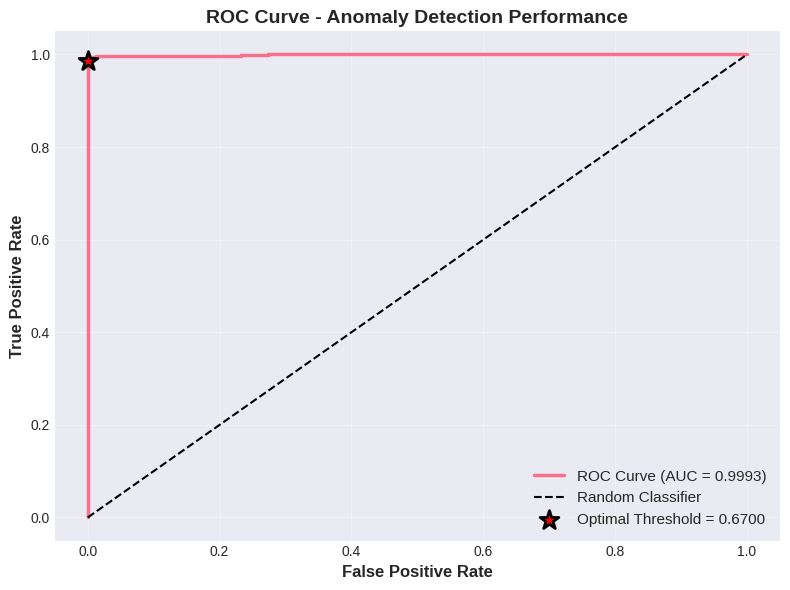

✓ ROC curve plotted


In [28]:

# ============================================================================
# PLOT ROC CURVE
# ============================================================================

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2.5, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')

# Find the optimal index for plotting the optimal threshold on ROC curve
optimal_idx = np.argmin(np.abs(roc_thresholds - optimal_threshold))
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], s=200, c='red', marker='*',
            edgecolors='black', linewidths=2, zorder=5,
            label=f'Optimal Threshold = {optimal_threshold:.4f}')

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - Anomaly Detection Performance', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ ROC curve plotted")



 ### 12.2 Precision-Recall Curve


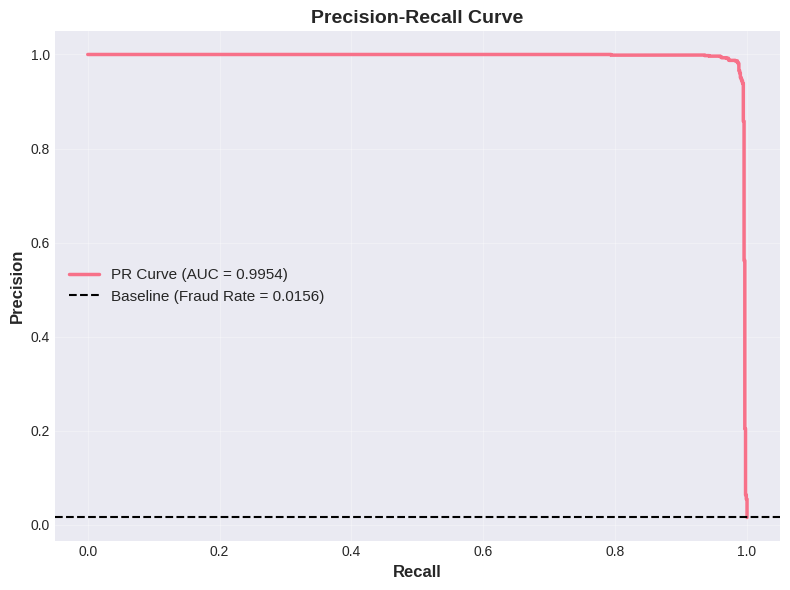

✓ Precision-Recall curve plotted


In [25]:

# ============================================================================
# PLOT PRECISION-RECALL CURVE
# ============================================================================

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2.5, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.axhline(y=labels_list.mean(), color='k', linestyle='--', linewidth=1.5,
            label=f'Baseline (Fraud Rate = {labels_list.mean():.4f})')

plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Precision-Recall curve plotted")


 ### 12.3 Confusion Matrix


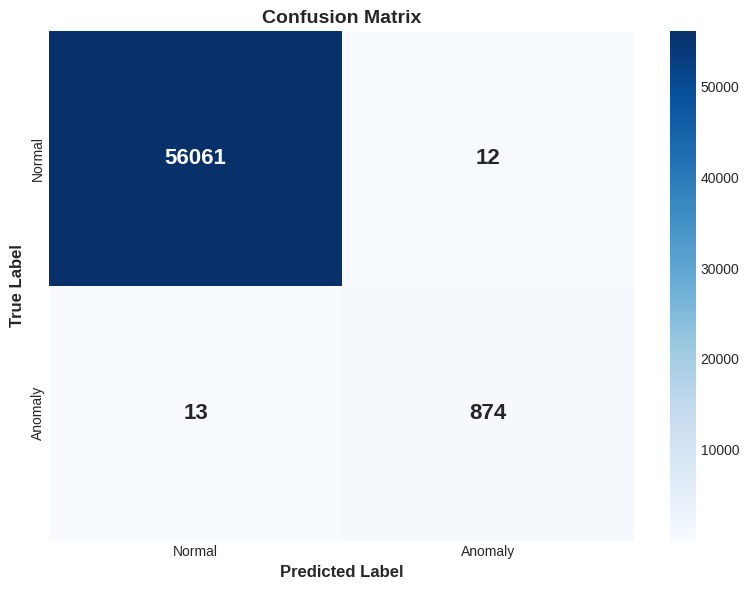


📊 Confusion Matrix Breakdown:
  True Negatives:   56061
  False Positives:     12
  False Negatives:     13
  True Positives:     874

  Specificity: 0.9998
  Sensitivity: 0.9853


In [26]:

# ============================================================================
# PLOT CONFUSION MATRIX
# ============================================================================

cm = confusion_matrix(labels_list, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            annot_kws={'size': 16, 'weight': 'bold'})

plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print confusion matrix statistics
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Confusion Matrix Breakdown:")
print(f"  True Negatives:  {tn:6d}")
print(f"  False Positives: {fp:6d}")
print(f"  False Negatives: {fn:6d}")
print(f"  True Positives:  {tp:6d}")
print(f"\n  Specificity: {tn/(tn+fp):.4f}")
print(f"  Sensitivity: {tp/(tp+fn):.4f}")


 ### 12.4 Anomaly Score Distribution


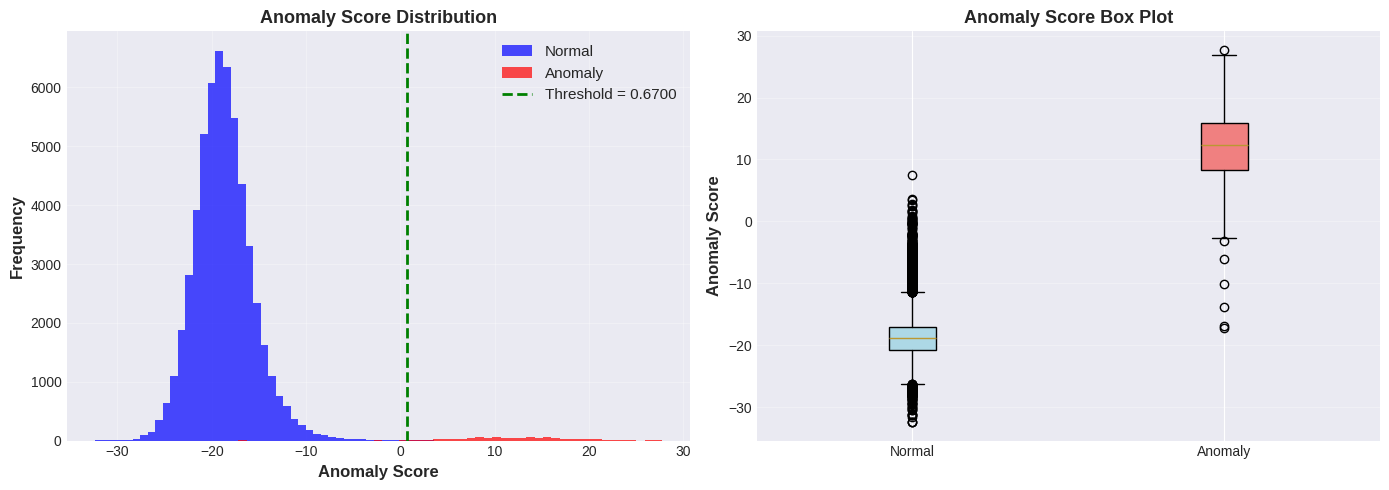

✓ Score distribution plots created

📈 Score Statistics:
  Normal samples:
    Mean: -18.708074
    Std:  3.128349
  Anomaly samples:
    Mean: 12.044861
    Std:  5.684192


In [29]:


# ============================================================================
# PLOT ANOMALY SCORE DISTRIBUTIONS
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(scores[labels_list == 0], bins=50, alpha=0.7, label='Normal', color='blue')
axes[0].hist(scores[labels_list == 1], bins=50, alpha=0.7, label='Anomaly', color='red')
axes[0].axvline(optimal_threshold, color='green', linestyle='--', linewidth=2,
                label=f'Threshold = {optimal_threshold:.4f}')
axes[0].set_xlabel('Anomaly Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Anomaly Score Distribution', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Box plot
data_to_plot = [scores[labels_list == 0], scores[labels_list == 1]]
bp = axes[1].boxplot(data_to_plot, labels=['Normal', 'Anomaly'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].set_ylabel('Anomaly Score', fontsize=12, fontweight='bold')
axes[1].set_title('Anomaly Score Box Plot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Score distribution plots created")

# Print statistics
print(f"\n📈 Score Statistics:")
print(f"  Normal samples:")
print(f"    Mean: {scores[labels_list == 0].mean():.6f}")
print(f"    Std:  {scores[labels_list == 0].std():.6f}")
print(f"  Anomaly samples:")
print(f"    Mean: {scores[labels_list == 1].mean():.6f}")
print(f"    Std:  {scores[labels_list == 1].std():.6f}")



 ### 12.5 Sample Reconstructions




Visualizing sample reconstructions...


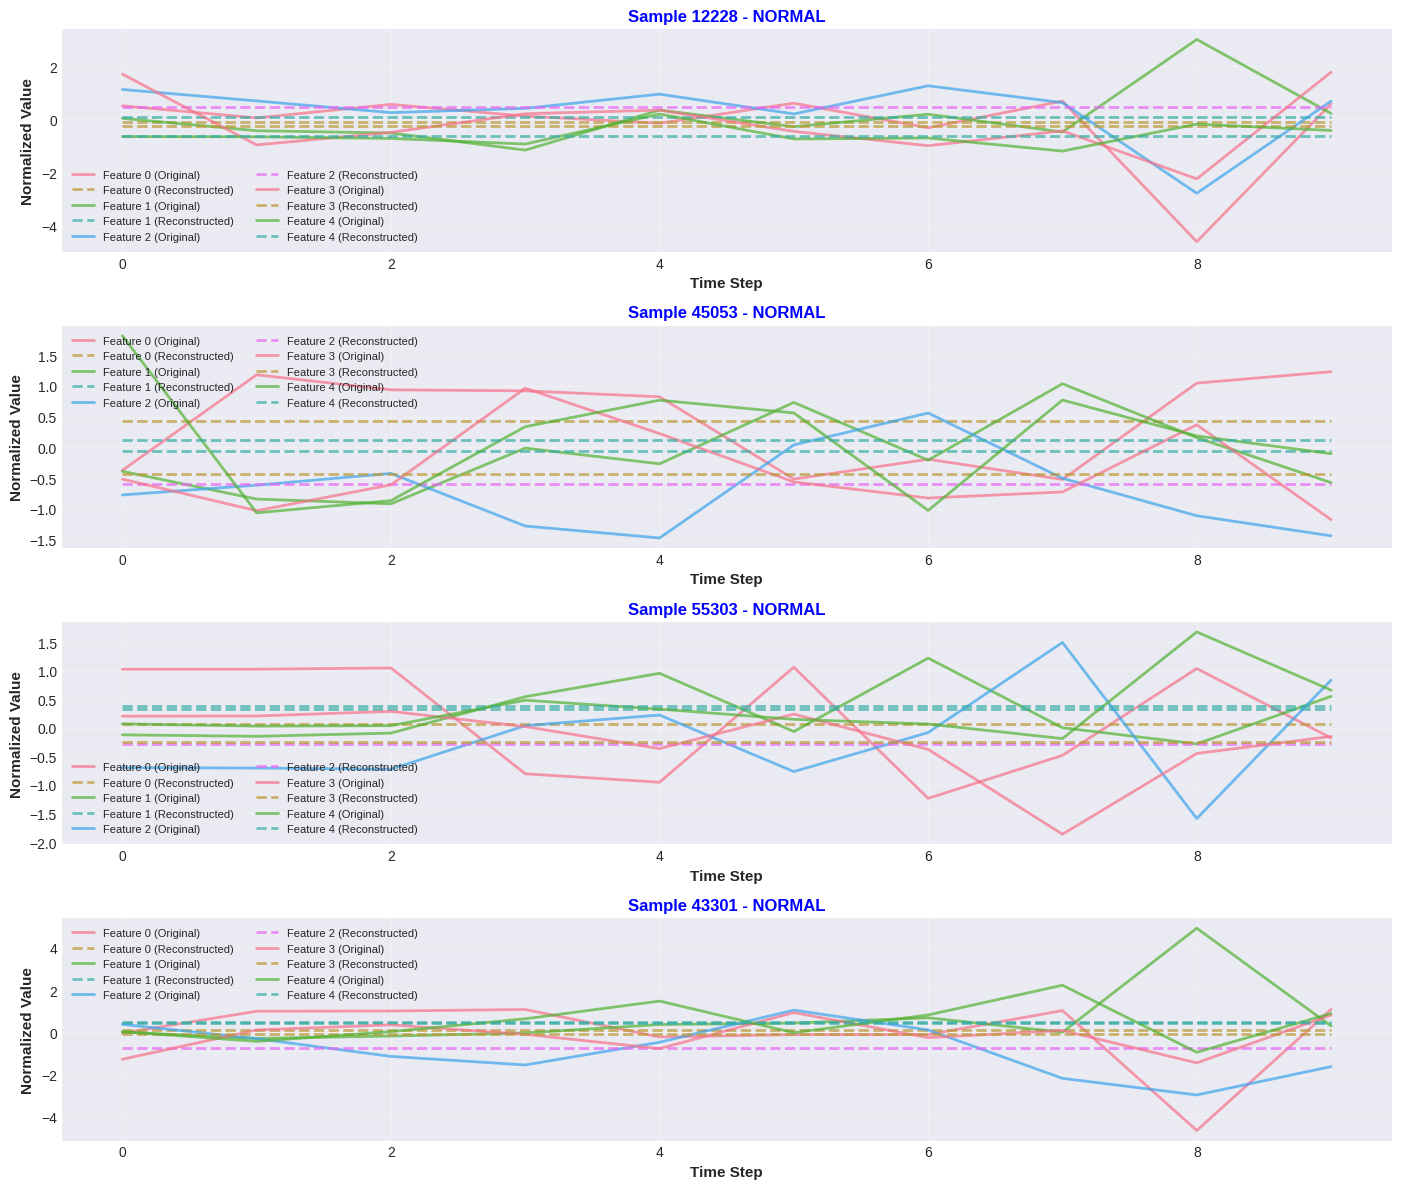

✓ Sample reconstructions visualized


In [31]:

# ============================================================================
# VISUALIZE SAMPLE RECONSTRUCTIONS
# ============================================================================

print("\nVisualizing sample reconstructions...")

# Get a few test samples
num_samples = 4
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(num_samples, 1, figsize=(14, 3*num_samples))
if num_samples == 1:
    axes = [axes]

model.eval()
with torch.no_grad():
    for idx, ax in zip(sample_indices, axes):
        # Get sample
        sample = torch.tensor(X_test[idx:idx+1], dtype=torch.float32).to(DEVICE)
        label = y_test[idx]

        # Reconstruct - correctly unpack all three return values, discarding the third
        z, recon, _ = model(sample)

        # Convert to numpy
        original = sample[0].cpu().numpy()
        reconstructed = recon[0].cpu().numpy()

        # Plot first 5 features over time
        time_steps = range(WINDOW_SIZE)
        for feat_idx in range(min(5, feat_dim)):
            ax.plot(time_steps, original[:, feat_idx],
                   label=f'Feature {feat_idx} (Original)',
                   linestyle='-', linewidth=2, alpha=0.7)
            ax.plot(time_steps, reconstructed[:, feat_idx],
                   label=f'Feature {feat_idx} (Reconstructed)',
                   linestyle='--', linewidth=2, alpha=0.7)

        ax.set_xlabel('Time Step', fontsize=11, fontweight='bold')
        ax.set_ylabel('Normalized Value', fontsize=11, fontweight='bold')
        ax.set_title(f'Sample {idx} - {"ANOMALY" if label == 1 else "NORMAL"}',
                    fontsize=12, fontweight='bold',
                    color='red' if label == 1 else 'blue')
        ax.legend(loc='best', fontsize=8, ncol=2)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Sample reconstructions visualized")


 ## 💾 Section 13: Save Model and Artifacts



In [32]:

# ============================================================================
# SAVE MODEL CHECKPOINT
# ============================================================================

save_path = "/content/drive/MyDrive/Credit-Card-Fraud-Anomaly-Detection/data/artifacts.pth"

checkpoint = {
    'model_state_dict': model.state_dict(),
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_ae_state_dict': optimizer_ae.state_dict(),
    'optimizer_gen_state_dict': optimizer_gen.state_dict(),
    'optimizer_disc_state_dict': optimizer_disc.state_dict(),
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_,
    'z_mean': z_mean,
    'z_inv_cov': z_inv_cov,
    'config': {
        'window_size': WINDOW_SIZE,
        'feat_dim': feat_dim,
        'd_model': D_MODEL,
        'nhead': NHEAD,
        'num_encoder_layers': NUM_ENCODER_LAYERS,
        'latent_dim': LATENT_DIM,
        'optimal_threshold': optimal_threshold
    },
    'metrics': {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    },
    'history': history
}

torch.save(checkpoint, save_path)
print(f"✓ Model and artifacts saved to: {save_path}")



✓ Model and artifacts saved to: /content/drive/MyDrive/Credit-Card-Fraud-Anomaly-Detection/data/artifacts.pth


In [33]:

# ============================================================================
# SAVE TRAINING HISTORY AS CSV
# ============================================================================

history_df = pd.DataFrame(history)
history_path = "/mnt/data/training_history.csv"
history_df.to_csv(history_path, index=False)
print(f"✓ Training history saved to: {history_path}")


✓ Training history saved to: /mnt/data/training_history.csv


 ## 📝 Section 14: Summary and Conclusions



In [34]:

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print(f"\n📊 Dataset:")
print(f"  Total sequences: {len(sequences):,}")
print(f"  Training samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Anomaly ratio: {labels.mean():.4%}")

print(f"\n🏗️  Model Architecture:")
print(f"  Window size: {WINDOW_SIZE}")
print(f"  Features: {feat_dim}")
print(f"  Transformer d_model: {D_MODEL}")
print(f"  Attention heads: {NHEAD}")
print(f"  Encoder layers: {NUM_ENCODER_LAYERS}")
print(f"  Latent dimension: {LATENT_DIM}")
print(f"  Total parameters: {count_parameters(model) + count_parameters(generator) + count_parameters(discriminator):,}")

print(f"\n🎯 Performance Metrics:")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(f"  PR-AUC:  {pr_auc:.4f}")
print(f"  Optimal Threshold: {optimal_threshold:.6f}")

print(f"\n⚙️  Training Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Loss weights: recon={W_RECON}, contrast={W_CONTRAST}, adv={W_ADV}")

print(f"\n💾 Saved Artifacts:")
print(f"  ✓ Model checkpoint: {save_path}")
print(f"  ✓ Training history: {history_path}")

print("\n" + "="*70)
print("EXPERIMENT COMPLETED SUCCESSFULLY")
print("="*70)



SUMMARY

📊 Dataset:
  Total sequences: 284,798
  Training samples: 227,838
  Test samples: 56,960
  Anomaly ratio: 1.5572%

🏗️  Model Architecture:
  Window size: 10
  Features: 29
  Transformer d_model: 64
  Attention heads: 4
  Encoder layers: 2
  Latent dimension: 64
  Total parameters: 126,495

🎯 Performance Metrics:
  ROC-AUC: 0.9993
  PR-AUC:  0.9954
  Optimal Threshold: 0.670000

⚙️  Training Configuration:
  Epochs: 20
  Batch size: 256
  Learning rate: 0.0005
  Loss weights: recon=0.3, contrast=0.2, adv=0.01

💾 Saved Artifacts:
  ✓ Model checkpoint: /content/drive/MyDrive/Credit-Card-Fraud-Anomaly-Detection/data/artifacts.pth
  ✓ Training history: /mnt/data/training_history.csv

EXPERIMENT COMPLETED SUCCESSFULLY


 ## 🔍 Section 15: Model Loading (Optional)


In [35]:

# ============================================================================
# LOAD MODEL FROM CHECKPOINT (EXAMPLE)
# ============================================================================

def load_model_from_checkpoint(checkpoint_path, device='cpu'):
    """
    Load trained model from checkpoint.

    Args:
        checkpoint_path: Path to saved checkpoint
        device: Device to load model on

    Returns:
        model, generator, discriminator, scaler_params, config, metrics
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Recreate model
    config = checkpoint['config']
    model = TransformerAutoencoder(
        feat_dim=config['feat_dim'],
        d_model=config['d_model'],
        nhead=config['nhead'],
        num_layers=config['num_encoder_layers'],
        latent_dim=config['latent_dim']
    ).to(device)

    generator = build_generator(config['latent_dim']).to(device)
    discriminator = build_discriminator(config['latent_dim']).to(device)

    # Load state dicts
    model.load_state_dict(checkpoint['model_state_dict'])
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

    # Set to eval mode
    model.eval()
    generator.eval()
    discriminator.eval()

    scaler_params = {
        'mean': checkpoint['scaler_mean'],
        'scale': checkpoint['scaler_scale']
    }

    return model, generator, discriminator, scaler_params, config, checkpoint['metrics']

print("✓ Model loading function defined")
print("\nTo load the model later, use:")
print("  model, gen, disc, scaler_params, config, metrics = load_model_from_checkpoint(save_path)")


✓ Model loading function defined

To load the model later, use:
  model, gen, disc, scaler_params, config, metrics = load_model_from_checkpoint(save_path)
